<a href="https://colab.research.google.com/github/pranay8297/ExpNotebooks/blob/main/blur_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Cropping Experiments

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from PIL import Image

In [2]:
df = pd.read_csv('red_rectangles.csv')

In [3]:
df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,red_rectangle,18,71,422,208,2121009251_722_old_meter_final_kwh_evidence.jpg,450,800
1,red_rectangle,43,40,382,154,21220031700_662_old_meter_final_kwh_evidence.jpg,450,800
2,red_rectangle,5,63,442,198,212207654509_337_old_meter_final_kwh_evidence.jpg,450,800
3,red_rectangle,28,105,406,184,2123000129_776_old_meter_final_kwh_evidence.jpg,450,800
4,red_rectangle,36,150,382,149,21230029958_489_old_meter_final_kwh_evidence.jpg,450,800


In [5]:
img_source = Path('../Bihar Image jan2025/old_meter_final_kwh_evidence')

In [ ]:
dest = Path('./red_rectangle_crops')
dest.mkdir(exist_ok=True)

def crop_image(image: Image, x, y, w, h):
    return image.crop((x, y, w, h))

for row in df.iterrows():
    try:
        img_path, x, y, w, h = row[1]['image_name'], row[1]['bbox_x'], row[1]['bbox_y'], row[1]['bbox_width'], row[1]['bbox_height']
        image = Image.open(img_source / img_path)
        cropped_image = crop_image(image, x, y, w, h)
        cropped_image.save(dest / img_path)
    except Exception as e:
        print(e)
        print(img_path)

In [21]:
import cv2
from pathlib import Path

# Destination folder for cropped images
dest = Path('./red_rectangle_crops')
dest.mkdir(exist_ok=True)

def crop_image_cv2(img, x, y, w, h):
    # img is a NumPy array (H × W × C); slicing keeps the original aspect
    return img[y:y+h, x:x+w]

for _, row in df.iterrows():
    img_name = row['image_name']
    x, y = int(row['bbox_x']), int(row['bbox_y'])
    w, h = int(row['bbox_width']), int(row['bbox_height'])
    src_path = img_source / img_name
    dst_path = dest / img_name

    try:
        # Read image (as BGR); returns None if file not found or unreadable
        img = cv2.imread(str(src_path))
        if img is None:
            print(f"Failed to load {src_path}")
            continue

        # Perform crop
        cropped = crop_image_cv2(img, x, y, w, h)

        # Save cropped patch in same format as original
        cv2.imwrite(str(dst_path), cropped)

    except Exception as e:
        print(f"Error processing {img_name}: {e}")


Error processing 2132001365_31_old_meter_final_kwh_evidence.jpg: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:929: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'



In [23]:
# import cv2
# import numpy as np
# from typing import Tuple, Optional

# def crop_meter_display(
#     img: np.ndarray,
#     lower_hsv: Tuple[int,int,int]=(40, 100, 100),
#     upper_hsv: Tuple[int,int,int]=(90, 255, 255),
#     min_area_ratio: float=0.02,
#     margin_ratio: float=0.02
# ) -> Optional[np.ndarray]:
#     """
#     Extract the LCD window from a meter photo.

#     Steps:
#       1. HSV threshold for green backlight → morphological close
#       2. findContours → filter by area (>min_area_ratio of img) → pick largest
#       3. if none found, fallback to adaptive grayscale threshold + close → repeat contour filter
#       4. expand the bbox by margin_ratio, clamp to image bounds
#       5. crop & rotate to ensure width >= height

#     Args:
#         img:        Input BGR image as NumPy array.
#         lower_hsv:  Lower HSV bound for initial mask.
#         upper_hsv:  Upper HSV bound for initial mask.
#         min_area_ratio:  Ignore contours smaller than this fraction of (H*W).
#         margin_ratio:    Pad the detected box by this fraction of its size.

#     Returns:
#         Cropped BGR image of the display, or None if no region found.
#     """
#     h_img, w_img = img.shape[:2]
#     img_area = h_img * w_img

#     def find_best_contour(mask: np.ndarray) -> Optional[Tuple[int,int,int,int]]:
#         cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         # filter by area
#         valid = [c for c in cnts if cv2.contourArea(c) >= min_area_ratio * img_area]
#         if not valid:
#             return None
#         x,y,w,h = cv2.boundingRect(max(valid, key=cv2.contourArea))
#         return x,y,w,h

#     # 1) HSV mask
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, np.array(lower_hsv), np.array(upper_hsv))

#     # adaptive kernel: ~1% of image dims
#     k = max(3, int(min(h_img, w_img) * 0.01)) | 1  # ensure odd
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k,k))
#     mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

#     bbox = find_best_contour(mask)

#     # 2) fallback to grayscale/adaptive if needed
#     if bbox is None:
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         # invert so display (dark digits on bright bg or vice versa) stands out
#         thr = cv2.adaptiveThreshold(
#             gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#             cv2.THRESH_BINARY_INV, blockSize=51, C=5
#         )
#         thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=2)
#         bbox = find_best_contour(thr)

#     if bbox is None:
#         return None

#     # 3) expand by margin
#     x,y,w,h = bbox
#     mx = int(w * margin_ratio)
#     my = int(h * margin_ratio)
#     x1 = max(0, x - mx)
#     y1 = max(0, y - my)
#     x2 = min(w_img, x + w + mx)
#     y2 = min(h_img, y + h + my)

#     # 4) crop & rotate if vertical
#     crop = img[y1:y2, x1:x2]
#     if crop.size == 0:
#         return None
#     if crop.shape[0] > crop.shape[1]:
#         crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)

#     return crop


In [51]:
import cv2
import numpy as np
from typing import Tuple, Optional

def crop_meter_display(
    img: np.ndarray,
    lower_hsv: Tuple[int,int,int]=(40, 100, 100),
    upper_hsv: Tuple[int,int,int]=(90, 255, 255),
    min_area_ratio: float=0.005,
    margin_ratio: float=0.02
) -> Optional[np.ndarray]:
    h_img, w_img = img.shape[:2]
    img_area = h_img * w_img

    def get_union_bbox(cnts):
        # filter by area
        valid = [c for c in cnts if cv2.contourArea(c) >= min_area_ratio * img_area]
        if not valid:
            return None
        # union of all bounding rects
        xs, ys, xe, ye = [], [], [], []
        for c in valid:
            x,y,w,h = cv2.boundingRect(c)
            xs.append(x); ys.append(y)
            xe.append(x+w); ye.append(y+h)
        return min(xs), min(ys), max(xe)-min(xs), max(ye)-min(ys)

    # ---- 1. Try HSV-based mask ----
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array(lower_hsv), np.array(upper_hsv))

    # bridge gaps: dilate + close
    ksize = max(3, int(min(h_img, w_img)*0.01)) | 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    bbox = get_union_bbox(cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])

    # ---- 2. Fallback to adaptive-threshold if needed ----
    if bbox is None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thr = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, blockSize=31, C=2
        )
        thr = cv2.dilate(thr, kernel, iterations=1)
        thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=2)
        bbox = get_union_bbox(cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0])

    if bbox is None:
        return None

    # ---- 3. Expand & clamp ----
    x,y,w,h = bbox
    dx = int(w * margin_ratio)
    dy = int(h * margin_ratio)
    x1, y1 = max(0, x-dx), max(0, y-dy)
    x2, y2 = min(w_img, x+w+dx), min(h_img, y+h+dy)

    # ---- 4. Crop & rotate if needed ----
    crop = img[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    if crop.shape[0] > crop.shape[1]:
        crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)

    return crop


In [156]:
import cv2
import numpy as np
from typing import Tuple, Optional

def crop_meter_display(
    img: np.ndarray,
    lower_hsv: Tuple[int,int,int]=(40, 100, 100),
    upper_hsv: Tuple[int,int,int]=(90, 255, 255),
    min_area_ratio: float=0.005,
    margin_ratio: float=0.02,
    hsv_width_min_ratio: float=0.5,
    hsv_area_min_ratio: float=0.05,
    hsv_aspect_min: float=0.2,
    hsv_aspect_max: float=0.5
) -> Optional[np.ndarray]:
    h_img, w_img = img.shape[:2]
    img_area = h_img * w_img


    def get_union_bbox(cnts, stage: str):
        valid = [c for c in cnts if cv2.contourArea(c) >= min_area_ratio * img_area]

        if not valid:
            return None
        xs, ys, xe, ye = [], [], [], []
        for c in valid:
            x,y,w,h = cv2.boundingRect(c)
            xs.append(x); ys.append(y)
            xe.append(x+w); ye.append(y+h)
        bbox = (min(xs), min(ys), max(xe)-min(xs), max(ye)-min(ys))

        return bbox

    def try_hsv_mask():

        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        m = cv2.inRange(hsv, np.array(lower_hsv), np.array(upper_hsv))
        k = max(3, int(min(h_img, w_img)*0.01)) | 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k,k))
        m = cv2.dilate(m, kernel, iterations=1)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel, iterations=2)

        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bbox = get_union_bbox(cnts, "HSV")
        if bbox is None:
            return None

        x, y, w, h = bbox

        if w < hsv_width_min_ratio * w_img:

            return None

        area = w * h
        aspect = h / w if w else 0


        # 1) width check
        if w < hsv_width_min_ratio * w_img:

            return None
        # 2) area check
        if area < hsv_area_min_ratio * img_area:

            return None
        # 3) aspect‐ratio check
        if not (hsv_aspect_min < aspect < hsv_aspect_max):

            return None

        return bbox

    def try_adaptive_thresh():

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thr = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, blockSize=31, C=2
        )
        k = max(3, int(min(h_img, w_img)*0.01)) | 1

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k,k))
        thr = cv2.dilate(thr, kernel, iterations=1)
        thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=2)
        cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return get_union_bbox(cnts, "THR")

    def try_hough():

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        lines = cv2.HoughLinesP(
            edges, 1, np.pi/180, threshold=50,
            minLineLength=int(w_img*0.4), maxLineGap=20
        )
        if lines is None:
            return None

        horiz, vert = [], []
        for x1,y1,x2,y2 in lines[:,0]:
            if abs(y2-y1) < abs(x2-x1)*0.2:
                horiz.append((x1,y1,x2,y2))
            elif abs(x2-x1) < abs(y2-y1)*0.2:
                vert.append((x1,y1,x2,y2))

        if not horiz or not vert:

            return None
        top = min(min(y1,y2) for x1,y1,x2,y2 in horiz)
        bottom = max(max(y1,y2) for x1,y1,x2,y2 in horiz)
        left = min(min(x1,x2) for x1,y1,x2,y2 in vert)
        right = max(max(x1,x2) for x1,y1,x2,y2 in vert)
        bbox = (left, top, right-left, bottom-top)

        return bbox

    def try_projection():

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        grad = np.abs(sx) + np.abs(sy)
        col_mean = np.mean(grad, axis=0)
        row_mean = np.mean(grad, axis=1)
        max_col = col_mean.max()
        max_row = row_mean.max()

        cidx = np.where(col_mean > 0.2*max_col)[0]
        ridx = np.where(row_mean > 0.2*max_row)[0]

        if cidx.size == 0 or ridx.size == 0:
            return None
        x1, x2 = cidx.min(), cidx.max()
        y1, y2 = ridx.min(), ridx.max()
        bbox = (x1, y1, x2-x1, y2-y1)
        return bbox

    # try each method in turn
    for fn in (try_hsv_mask, try_adaptive_thresh, try_hough, try_projection):

        bbox = fn()
        if bbox is not None:

            x,y,w,h = bbox
            # expand & clamp
            dx, dy = int(w * margin_ratio), int(h * margin_ratio)
            x1, y1 = max(0, x-dx), max(0, y-dy)
            x2, y2 = min(w_img, x+w+dx), min(h_img, y+h+dy)

            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue
            # enforce horizontal
            if crop.shape[0] > crop.shape[1]:
                crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)

            return crop
    return None


In [25]:
cropped_imgs = list(dest.glob('*.jpg'))
len(cropped_imgs), cropped_imgs[0]

(325,
 PosixPath('red_rectangle_crops/213205019400_736_old_meter_final_kwh_evidence.jpg'))

[INIT] image size: 408x156, area: 63648
[MAIN] attempting: try_hsv_mask

[try_hsv_mask] HSV mask stage
[HSV] total/valid contours: 3/1
[HSV] union bbox: (303, 43, 34, 18)
[try_hsv_mask] width_ratio=0.08 (requires ≥ 0.50)
[try_hsv_mask] rejected: too narrow, falling back
[MAIN] try_hsv_mask returned None; trying next
[MAIN] attempting: try_adaptive_thresh

[try_adaptive_thresh] starting adaptive threshold stage
[try_adaptive_thresh] kernel size: 3
[THR] total/valid contours: 18/2
[THR] union bbox: (0, 0, 408, 156)
[MAIN] try_adaptive_thresh succeeded with bbox (0, 0, 408, 156)
[MAIN] clamped & padded bbox: (0,0,408,156)


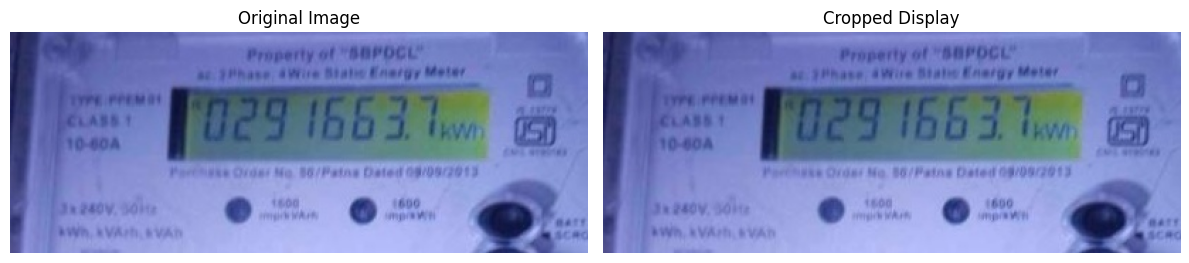

In [155]:
# import cv2
import matplotlib.pyplot as plt
# Load and crop
img = cv2.imread(cropped_imgs[18])
disp = crop_meter_display(img)
# Create side-by-side display
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Original image
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')
# Cropped display or fallback message
if disp is not None:
    axs[1].imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Cropped Display')
else:
    axs[1].text(0.5, 0.5, "Display not found",ha='center', va='center', fontsize=14)
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [158]:
from tqdm import tqdm

crop_dest = Path('./lcd_crops')
crop_dest.mkdir(exist_ok=True)

for im_path in tqdm(dest.iterdir()):
    img = cv2.imread(str(im_path))

    if img is None:
        print(f"Failed to load {im_path}")
        continue

    disp = crop_meter_display(img)
    if disp is not None:
        cv2.imwrite(str(crop_dest / im_path.name), disp)
    else:
        print(f"No Display found for: {im_path.name}")

98it [00:00, 307.29it/s]

Failed to load red_rectangle_crops/.DS_Store
No Display found for: 2132015916_04012025_5422__old_meter_final_kwh_evidence.jpg


332it [00:00, 456.88it/s]


In [160]:
import cv2
import numpy as np
from typing import Tuple, Optional

def crop_meter_display_by_hull(
    img: np.ndarray,
    bright_thresh: int = 200,
    dark_thresh: int = 50,
    morph_kernel: Tuple[int,int] = (5,5),
    morph_iterations: int = 2
) -> Optional[np.ndarray]:
    """
    Crop out the meter’s LCD by brightness‐thresholding + convex‐hull.

    1. Gray-scale → two binary masks:
       • mask_bright: pixels > bright_thresh  (backlit screens)
       • mask_dark:   pixels < dark_thresh    (non-backlit screens)
       → combined mask captures both cases.
    2. Morphological open+close to clean up noise.
    3. Find all contours, take their convex hull (a “rubber-band” around them).
    4. Bounding‐rect of that hull is our screen ROI.
    5. Crop & rotate to ensure width ≥ height.

    Args:
        img:            BGR input image.
        bright_thresh:  threshold for bright backlit displays.
        dark_thresh:    threshold for dark (non-backlit) displays.
        morph_kernel:   kernel size for morphology.
        morph_iterations: how many times to close/open.

    Returns:
        Cropped BGR image of the display, or None if no region found.
    """
    # 1) Gray + dual threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, m1 = cv2.threshold(gray, bright_thresh, 255, cv2.THRESH_BINARY)
    _, m2 = cv2.threshold(gray, dark_thresh,   255, cv2.THRESH_BINARY_INV)
    mask = cv2.bitwise_or(m1, m2)

    # 2) Clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=morph_iterations)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)

    # 3) Convex hull of all contours
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None
    all_pts = np.vstack(cnts)
    hull = cv2.convexHull(all_pts)

    # 4) Crop bounding rect
    x, y, w, h = cv2.boundingRect(hull)
    crop = img[y:y+h, x:x+w]
    if crop.size == 0:
        return None

    # 5) Rotate if vertical
    if crop.shape[0] > crop.shape[1]:
        crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)

    return crop

In [190]:
is_valid = []
for i in dest.iterdir():
    is_valid.append({'name': i.name, 'is_ocrable': 1})

In [191]:
df = pd.DataFrame(is_valid)
df.to_csv('is_ocrable.csv', index=False)

# So, lets model it now

In [386]:
df = pd.read_csv('is_ocrable_correct.csv')
df.head()

,name,is_ocrable
0,213205019400_736_old_meter_final_kwh_evidence.jpg,1
1,215200326261_298_old_meter_final_kwh_evidence.jpg,1
2,212308350694_778_old_meter_final_kwh_evidence.jpg,1
3,2123024713_03012025_0831__old_meter_final_kwh_...,0
4,22350002843_07012025_1424__old_meter_final_kwh...,0


In [387]:
df['is_ocrable'].value_counts()

is_ocrable
0    175
1    156
Name: count, dtype: int64

In [390]:
# list(df['name'])
source = Path('./lcd_crops')
names = set([i.name for i in source.iterdir()])
for i in list(df['name']):
    try:
        assert i in names
    except:
        print(i)

2132015916_04012025_5422__old_meter_final_kwh_evidence.jpg


In [392]:
df.loc[df['name'] == '2132015916_04012025_5422__old_meter_final_kwh_evidence.jpg']

,name,is_ocrable
83,2132015916_04012025_5422__old_meter_final_kwh_...,1


In [ ]:
df.drop(df.index[df['name'] == '2132015916_04012025_5422__old_meter_final_kwh_evidence.jpg'], inplace=True)

In [395]:

source = Path('./lcd_crops')
names = set([i.name for i in source.iterdir()])
for i in list(df['name']):
    try:
        assert i in names
    except:
        print(i)

In [396]:
df.to_csv('is_ocrable_correct.csv', index=False)

In [401]:
df.head()

,name,is_ocrable
0,213205019400_736_old_meter_final_kwh_evidence.jpg,1
1,215200326261_298_old_meter_final_kwh_evidence.jpg,1
2,212308350694_778_old_meter_final_kwh_evidence.jpg,1
3,2123024713_03012025_0831__old_meter_final_kwh_...,0
4,22350002843_07012025_1424__old_meter_final_kwh...,0


In [402]:
import numpy as np

h = []
w = []
for _, i in df.iterrows():
    img = Image.open(source / i['name'])
    h.append(img.height)
    w.append(img.width)
np.mean(h), np.mean(w)

(np.float64(169.4181818181818), np.float64(371.54242424242426))

In [409]:
import torchvision.transforms as T

# MobileNetV3 default input resolution
INPUT_SIZE = 224

# Pool of candidate augmentations (each applied with p=1.0 when selected)
augmentation_pool = [
    T.RandomHorizontalFlip(p=1.0),
    T.RandomVerticalFlip(p=1.0),
    T.RandomPerspective(distortion_scale=0.5, p=1.0),
    T.RandomGrayscale(p=1.0),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    T.RandomAutocontrast(p=1.0),
]

train_transform = T.Compose([
    # 1) Resize/crop to square
    # T.Resize((INPUT_SIZE, INPUT_SIZE)),
    # 2) Apply exactly one augmentation from the pool
    T.RandomChoice(augmentation_pool),
    # 3) Mild rotation to add invariance
    T.RandomRotation(degrees=5),
    # 4) Convert to tensor + ImageNet-normalize
    # T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406],
    #             std =[0.229, 0.224, 0.225]),
])

val_transform = T.Compose([
    T.Resize((INPUT_SIZE, INPUT_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]),
])

In [411]:
source = Path('./lcd_crops')
good = list(df[df['is_ocrable'] != 0].name)
bad = list(df[df['is_ocrable'] == 0].name)

good_images = [train_transform(Image.open(source/i)) for i in good]
bad_images = [train_transform(Image.open(source/i)) for i in bad]

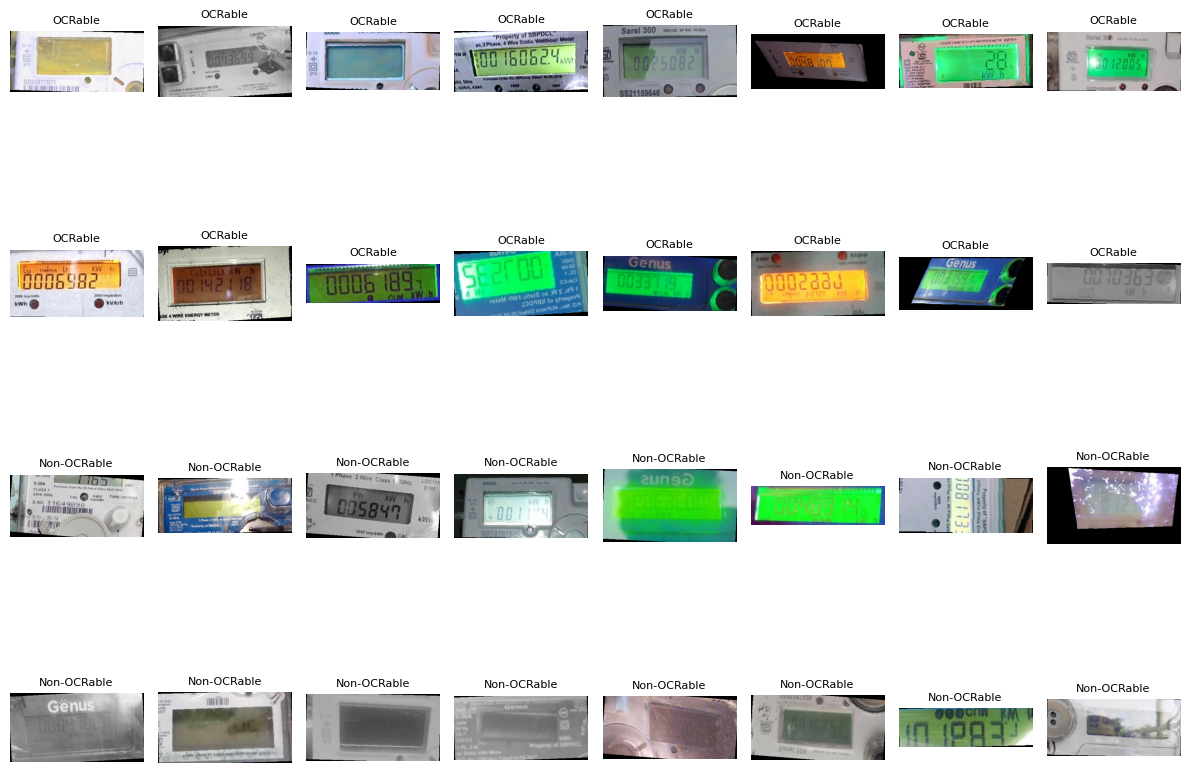

In [448]:
import random
import matplotlib.pyplot as plt

# assume good_images and bad_images are lists of tensors or PIL.Images
# if tensors, convert them back to numpy:
def to_numpy(img):
    if hasattr(img, 'permute'):
        # tensor: C×H×W -> H×W×C
        img = img.permute(1, 2, 0).cpu().numpy()
        # un-normalize if you normalized
        # img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        # img = img.clip(0, 1)
    return img

# pick 10 random samples each
good_samples = random.sample(good_images, 16)
bad_samples  = random.sample(bad_images,  16)

fig, axes = plt.subplots(4, 8, figsize=(12, 10))
axes = axes.flatten()

# plot good images in first 2 rows
for idx, img in enumerate(good_samples):
    axes[idx].imshow(to_numpy(img))
    axes[idx].axis('off')
    axes[idx].set_title("OCRable", fontsize=8)

# plot bad images in last 2 rows
for idx, img in enumerate(bad_samples, start=16):
    axes[idx].imshow(to_numpy(img))
    axes[idx].axis('off')
    axes[idx].set_title("Non-OCRable", fontsize=8)

plt.tight_layout()
plt.show()


In [492]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

def get_transforms(img_size: int = 224):
    import torchvision.transforms as T

    # MobileNetV3 default input resolution
    INPUT_SIZE = 224

    # Pool of candidate augmentations (each applied with p=1.0 when selected)
    augmentation_pool = [
        T.RandomHorizontalFlip(p=1.0),
        T.RandomVerticalFlip(p=1.0),
        T.RandomPerspective(distortion_scale=0.5, p=1.0),
        T.RandomGrayscale(p=1.0),
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
        T.RandomAutocontrast(p=1.0),
    ]

    train_transform = T.Compose([
        # 1) Resize/crop to square
        T.Resize((INPUT_SIZE, INPUT_SIZE)),
        # 2) Apply exactly one augmentation from the pool
        T.RandomChoice(augmentation_pool),
        # 3) Mild rotation to add invariance
        T.RandomRotation(degrees=5),
        # 4) Convert to tensor + ImageNet-normalize
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std =[0.229, 0.224, 0.225]),
    ])

    val_transform = T.Compose([
        T.Resize((INPUT_SIZE, INPUT_SIZE)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std =[0.229, 0.224, 0.225]),
    ])

    return train_transform, val_transform

class DS(Dataset):
    def __init__(self, df, source = Path('./lcd_crops'), is_valid = False):
        self.df = df
        self.images = [Image.open(source/i) for i in list(df['name'])]
        self.labels = list(df['is_ocrable'])
        self.train_transform, self.val_transform = get_transforms()
        self.is_valid = is_valid

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        tfm = self.val_transform if self.is_valid == True else self.train_transform
        img = tfm(img)
        return img, label

In [488]:
# split a dataframe into train and valid splits
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size=0.1, random_state=42)
train_ds = DS(df_train)
valid_ds = DS(df_valid, is_valid=True)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)

In [493]:
print(df_train['is_ocrable'].value_counts())
print(df_valid['is_ocrable'].value_counts())

is_ocrable
0    156
1    141
Name: count, dtype: int64
is_ocrable
0    19
1    14
Name: count, dtype: int64


In [466]:
batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
# batch[0].shape, batch[1].shape

In [491]:
for batch in iter(val_loader):
    print(batch[0].mean(), batch[0].std())
    # break

tensor(0.4826) tensor(1.0028)
tensor(0.4447) tensor(1.0537)
tensor(0.1726) tensor(0.6389)


In [504]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small

# ------------------ Configurable Hyperparameters ------------------
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
NUM_CLASSES = 2
LR = 3e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 16
NUM_EPOCHS_PHASE1 = 3
NUM_EPOCHS_PHASE2 = 35

# ------------------ DataLoaders (user must define) ------------------
# Assume `train_loader` and `val_loader` are already created DataLoader instances, e.g.:
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
# val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# ------------------ Model Setup ------------------
model = mobilenet_v3_small(pretrained=True)
in_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# ------------------ Phase 1: Train Only Last Layer ------------------
# Freeze all layers except the new classifier layer
for name, param in model.named_parameters():
    param.requires_grad = ("classifier.3" in name)

optimizer_phase1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

def train_epoch(loader, model, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        # clip grad norm
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        preds = outputs.argmax(dim=1)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    return total_loss/total_samples, total_correct/total_samples

def eval_epoch(loader, model, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            total_loss += loss.item() * imgs.size(0)
            total_correct += (preds == labels).sum().item()
            total_samples += imgs.size(0)
    return total_loss/total_samples, total_correct/total_samples

# best_state_dict = model.state_dict()
# best_acc = 0.0

print("Starting Phase 1: Training only the classifier layer")
for epoch in range(1, NUM_EPOCHS_PHASE1 + 1):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer_phase1, DEVICE)
    val_loss, val_acc     = eval_epoch(val_loader,   model, criterion, DEVICE)
    print(f"Phase1 Epoch {epoch}/{NUM_EPOCHS_PHASE1} - "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        best_state_dict = model.state_dict()

# ------------------ Phase 2: Fine-Tune All Layers ------------------
for param in model.parameters():
    param.requires_grad = True

del optimizer_phase1

optimizer_phase2 = optim.AdamW(model.parameters(), lr=5e-05, weight_decay=WEIGHT_DECAY)

print("\nStarting Phase 2: Fine-tuning all layers")
for epoch in range(1, NUM_EPOCHS_PHASE2 + 1):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer_phase2, DEVICE)
    val_loss, val_acc     = eval_epoch(val_loader,   model, criterion, DEVICE)
    print(f"Phase2 Epoch {epoch}/{NUM_EPOCHS_PHASE2} - "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        best_state_dict = model.state_dict()

print(f"Best Validation Accuracy: {best_acc:.4f}")
# ------------------ Load Best Model State Dict ------------------
model.load_state_dict(best_state_dict)

# # ------------------ Save the Fine-tuned Model ------------------
# torch.save(model.state_dict(), "mobilenet_v3_finetuned.pth")
# print("Fine-tuning complete. Model saved to mobilenet_v3_finetuned.pth")


Starting Phase 1: Training only the classifier layer
Phase1 Epoch 1/3 - Train Loss: 0.6686, Acc: 0.5758 | Val Loss: 0.6182, Acc: 0.6970
Phase1 Epoch 2/3 - Train Loss: 0.5779, Acc: 0.7475 | Val Loss: 0.6323, Acc: 0.5758
Phase1 Epoch 3/3 - Train Loss: 0.5230, Acc: 0.8148 | Val Loss: 0.6511, Acc: 0.5758

Starting Phase 2: Fine-tuning all layers
Phase2 Epoch 1/35 - Train Loss: 0.4944, Acc: 0.7879 | Val Loss: 0.6675, Acc: 0.5758
Phase2 Epoch 2/35 - Train Loss: 0.4359, Acc: 0.8384 | Val Loss: 0.6790, Acc: 0.6061
Phase2 Epoch 3/35 - Train Loss: 0.4110, Acc: 0.8350 | Val Loss: 0.6488, Acc: 0.6667
Phase2 Epoch 4/35 - Train Loss: 0.3581, Acc: 0.8586 | Val Loss: 0.7153, Acc: 0.6667
Phase2 Epoch 5/35 - Train Loss: 0.3536, Acc: 0.8721 | Val Loss: 0.6882, Acc: 0.6667
Phase2 Epoch 6/35 - Train Loss: 0.3284, Acc: 0.8754 | Val Loss: 0.5844, Acc: 0.7576
Phase2 Epoch 7/35 - Train Loss: 0.2765, Acc: 0.8889 | Val Loss: 0.5874, Acc: 0.7879
Phase2 Epoch 8/35 - Train Loss: 0.2650, Acc: 0.8990 | Val Loss: 0.55

<All keys matched successfully>

In [500]:
existing_state_dict = model.state_dict()

In [502]:
torch.save(best_state_dict, "mobilenet_v3_finetuned_9091.pth")

In [509]:
val_loader

In [516]:
valid_batch_images = torch.stack([valid_ds.val_transform(i) for i in valid_ds.images])
valid_batch_labels = torch.tensor(valid_ds.labels)

In [517]:
valid_batch_images.shape

torch.Size([33, 3, 224, 224])

In [518]:
valid_batch_labels

tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0])

In [520]:
model.eval()
valid_batch_images = valid_batch_images.to(DEVICE)
with torch.no_grad():
    valid_logits = model(valid_batch_images)

In [521]:
valid_logits.shape

torch.Size([33, 2])

In [522]:
valid_pred = valid_logits.argmax(dim=1)
valid_pred.shape

torch.Size([33])

In [530]:
mask = valid_pred.cpu() == valid_batch_labels

In [531]:
for idx, i in enumerate(mask):
    if i == False:
        print(idx)

1
4
27


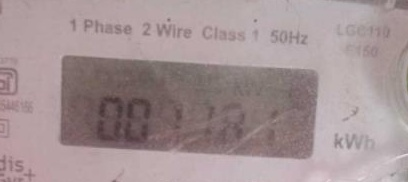

In [538]:
valid_ds.images[2]

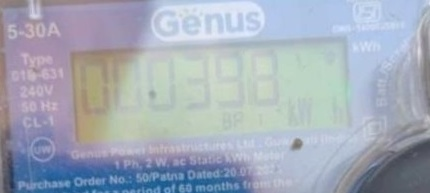

In [534]:
valid_ds.images[27]

In [535]:
del model

In [539]:
import torch
from PIL import Image
from strhub.data.module import SceneTextDataModule

In [540]:
parseq = torch.hub.load('baudm/parseq', 'parseq', pretrained=True).eval()
img_transform = SceneTextDataModule.get_transform(parseq.hparams.img_size)

Using cache found in /Users/pranaybindela/.cache/torch/hub/baudm_parseq_main
/Users/pranaybindela/miniforge3/envs/cryptonite/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


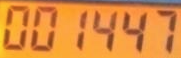

In [543]:
img_path = Path('/Users/pranaybindela/Desktop/pratik/ocr/makesense_labels/212_bihar_images/21320019885_425_old_meter_final_kwh_evidence.png')
img = Image.open(img_path).convert('RGB')
img

In [544]:
img = img_transform(img).unsqueeze(0)

logits = parseq(img)
logits.shape  # torch.Size([1, 26, 95]), 94 characters + [EOS] symbol



torch.Size([1, 26, 95])

In [545]:
pred = logits.softmax(-1)
label, confidence = parseq.tokenizer.decode(pred)
print('Decoded label = {}'.format(label[0]))

Decoded label = 001447


# Blur Detection using Gradient Mean and SV ratio


In [548]:
import cv2
import numpy as np

def compute_gradient_metric(img_gray: np.ndarray) -> float:
    """
    Compute mean Sobel gradient magnitude as a focus measure.
    """
    # Sobel gradients (first-order derivatives)
    gx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(gx**2 + gy**2)
    return grad_mag.mean()

def compute_sv_ratio(img_gray: np.ndarray, k: int = 5) -> float:
    """
    Compute the ratio of the sum of the top-k singular values to the total sum.
    Blurred images have higher concentration in top singular values.
    """
    # Downsample to speed up SVD
    small = cv2.resize(img_gray, (64, 64), interpolation=cv2.INTER_AREA)
    # Perform SVD
    _, s, _ = np.linalg.svd(small, full_matrices=False)
    top_k = np.sum(s[:k])
    total = np.sum(s)
    return top_k / total if total > 0 else 1.0

def is_blurry(img: np.ndarray,
              grad_thresh: float = 10.0,
              sv_thresh: float = 0.75) -> bool:
    """
    Returns True if the image is considered too blurry.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Compute metrics
    grad_score = compute_gradient_metric(gray)
    sv_score   = compute_sv_ratio(gray, k=5)
    # Flag as blurry if gradient too low or SVD ratio too high
    return (grad_score < grad_thresh) or (sv_score > sv_thresh)

# Example usage:
# img = cv2.imread('/path/to/image.jpg')
# if is_blurry(img):
#     print("Reject: Too blurry")
# else:
#     print("Proceed to OCR")


In [550]:
good = list(df[df['is_ocrable'] != 0].name)
bad = list(df[df['is_ocrable'] == 0].name)

In [552]:
source = Path('./lcd_crops')

get_gray_img = lambda img_path: cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2GRAY)

good_grad_scores = [compute_gradient_metric(get_gray_img(source/i)) for i in good]
good_sv_scores = [compute_sv_ratio(get_gray_img(source/i), k=5) for i in good]

bad_grad_scores = [compute_gradient_metric(get_gray_img(source/i)) for i in bad]
bad_sv_scores = [compute_sv_ratio(get_gray_img(source/i), k=5) for i in bad]

In [553]:
np.mean(good_grad_scores), np.mean(bad_grad_scores), np.min(good_grad_scores), np.max(bad_grad_scores)

(np.float64(48.70748149123633),
 np.float64(35.95288383783986),
 np.float64(15.431274425825064),
 np.float64(83.91923430960263))

In [554]:
np.mean(good_sv_scores), np.mean(good_sv_scores), np.min(good_sv_scores), np.max(good_sv_scores)

(np.float64(0.8026873265806044),
 np.float64(0.8026873265806044),
 np.float64(0.6733439637362885),
 np.float64(0.9140868874333107))

In [555]:
good_results = [is_blurry(cv2.imread(source/i)) for i in good]
bad_results = [is_blurry(cv2.imread(source/i)) for i in bad]

In [ ]:
good_results

In [ ]:
bad_results

# Exporting Models to TFLite

In [558]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_small

class WrappedModel(nn.Module):
    def __init__(self, base_model: nn.Module, mean: torch.Tensor, std: torch.Tensor):
        super().__init__()
        # Register as buffers so they’re part of the exported graph
        self.register_buffer('mean', mean.view(1, -1, 1, 1))
        self.register_buffer('std', std.view(1, -1, 1, 1))
        self.model = base_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Embedded normalization op
        x = (x - self.mean) / self.std
        return self.model(x)


In [562]:
DEVICE

device(type='mps')

In [560]:
# Load and adapt your MobileNet-V3
base = mobilenet_v3_small(pretrained=True)
in_feat = base.classifier[3].in_features
base.classifier[3] = nn.Linear(in_feat, NUM_CLASSES)

state_dict = torch.load("mobilenet_v3_finetuned_9091.pth")
base.load_state_dict(state_dict)

# Create normalization tensors
mean = torch.tensor([0.485, 0.456, 0.406])
std  = torch.tensor([0.229, 0.224, 0.225])

# Wrap and set to eval
wrapped = WrappedModel(base, mean, std).to(DEVICE).eval()

In [563]:
x = torch.randn(1, 3, 224, 224).to(DEVICE)
out = wrapped(x)

In [565]:
out[0]

tensor([ 0.2901, -0.3030], device='mps:0', grad_fn=<SelectBackward0>)

In [567]:
import torch

# Assume `wrapped` is your WrappedModel in eval mode on the correct device
# and `dummy` is torch.randn(1, 3, 224, 224, device=DEVICE)
dummy = torch.randn(1, 3, 224, 224, device=DEVICE)
np.object = object
# np.int = int
# np.float = float
# np.bool = bool
# Export the model to ONNX

torch.onnx.export(
    wrapped,                          # the wrapped PyTorch model
    dummy,                            # dummy input matching [1,3,224,224]
    "judge_model.onnx",               # output filename
    export_params=True,               # store trained weights
    opset_version=13,                 # ONNX opset version
    input_names=["input"],            # name of the input tensor
    output_names=["logits"],          # name of the output tensor
    dynamic_axes={                    # make batch dimension variable
        "input": {0: "batch_size"},
        "logits": {0: "batch_size"}
    }
)


In [568]:
!onnx-tf convert -i judge_model.onnx -o ./

/Users/pranaybindela/miniforge3/envs/cryptonite/lib/python3.10/site-packages/onnx/mapping.py:27: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  int(TensorProto.STRING): np.dtype(np.object)
Traceback (most recent call last):
  File "/Users/pranaybindela/miniforge3/envs/cryptonite/bin/onnx-tf", line 5, in <module>
    from onnx_tf.cli import main
  File "/Users/pranaybindela/miniforge3/envs/cryptonite/lib/python3.10/site-packages/onnx_tf/__init__.py", line 1, in <module>
    from . import backend
  File "/Users/pranaybindela/miniforge3/envs/cryptonite/lib/python3.10/site-packages/onnx_tf/backend.py", line 15, in <module>
    from onnx import defs
  File "/Users/pranaybindela/miniforge3/envs/cryptonite/lib/python3.10/site-packages/onnx/__init__.py", line 20, in <module>
    import onnx.helper  # noqa
  File "/Users/pranaybindela/miniforge3/envs/cryptonite/lib/python3.10/site-packages/onnx/helper.py", line 17, in <module>
    from onnx import 

# Coco JSON

In [569]:
import pandas as pd

In [573]:
df = pd.read_excel('./RED_REC_MANU.xls')
df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,RED_REC,19,165,562,173,2018005814_20250303110355_703_OldMeterPhoto.jpg,600,800
1,RED_REC,14,319,575,187,2018005814_20250303110743_231_OldMeterFinalkWh...,600,800
2,RED_REC,14,342,573,189,2018005814_20250303110926_185_OldMeterFinalrea...,600,800
3,RED_REC,21,59,554,180,2018005814_20250303111657_971_OldMeterRecorded...,600,800
4,RED_REC,19,171,560,234,2018005814_20250303112332_169_NewMeterPhoto.jpg,600,800


In [574]:
from tqdm import tqdm
import json

import cv2
from pathlib import Path

source = Path('../label_images/')

# Destination folder for cropped images
dest = Path('./manuvanth_red_rectangle_crops')
dest.mkdir(exist_ok=True)

def crop_image_cv2(img, x, y, w, h):
    # img is a NumPy array (H × W × C); slicing keeps the original aspect
    return img[y:y+h, x:x+w]

for _, row in tqdm(df.iterrows()):
    img_name = row['image_name']
    x, y = int(row['bbox_x']), int(row['bbox_y'])
    w, h = int(row['bbox_width']), int(row['bbox_height'])
    src_path = source / img_name
    dst_path = dest / img_name

    try:
        # Read image (as BGR); returns None if file not found or unreadable
        img = cv2.imread(str(src_path))
        if img is None:
            print(f"Failed to load {src_path}")
            continue

        # Perform crop
        cropped = crop_image_cv2(img, x, y, w, h)

        # Save cropped patch in same format as original
        cv2.imwrite(str(dst_path), cropped)

    except Exception as e:
        print(f"Error processing {img_name}: {e}")


2025it [00:04, 454.18it/s]


In [581]:
import json
import os
import cv2
import numpy as np

def crop_polygons_from_coco(
    coco_json_path: str,
    images_dir: str,
    output_dir: str
):
    """
    For each annotation in a COCO JSON, crops out the polygon region from its image.

    Args:
      coco_json_path: Path to COCO JSON annotation file.
      images_dir: Directory containing the images referenced in the JSON.
      output_dir: Directory where cropped polygon images will be saved.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load COCO annotations
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)

    # Build image lookup by id
    images_lookup = {img['id']: img for img in coco.get('images', [])}

    # Process each annotation
    c = 0
    for ann in coco.get('annotations', []):
        img_info = images_lookup.get(ann['image_id'])
        if not img_info:
            print('Image info not found')
            continue

        img_path = os.path.join(images_dir, img_info['file_name'])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"⚠️ Could not load image: {img_path}")
            continue

        # Handle one or more polygon parts
        for part_idx, poly in enumerate(ann.get('segmentation', [])):
            pts = np.array(poly).reshape(-1, 2).astype(np.int32)

            # Create mask for the polygon
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask, [pts], 255)

            # Compute bounding rect for the polygon
            x, y, w, h = cv2.boundingRect(pts)

            # Apply mask and crop
            cropped = cv2.bitwise_and(img, img, mask=mask)[y:y+h, x:x+w]

            # Save output
            base, _ = os.path.splitext(img_info['file_name'])
            out_name = f"{base}_ann{ann['id']}_part{part_idx}.png"
            out_path = os.path.join(output_dir, out_name)
            cv2.imwrite(out_path, cropped)
            c += 1
        if c >= 10:
            break

    print(f"✅ Cropped polygons saved to: {output_dir}")

In [576]:
!pwd

/Users/pranaybindela/Desktop/pratik/ocr/red_rectangle


In [582]:
crop_polygons_from_coco(
    coco_json_path='manuvanth_digit_bounding_box/digit_bounding_boxes.json',
    images_dir = '/Users/pranaybindela/Desktop/pratik/ocr/red_rectangle/manuvanth_red_rectangle_crops',
    output_dir='manuvanth_digit_bounding_box/digit_bounding_boxes'
)

✅ Cropped polygons saved to: manuvanth_digit_bounding_box/digit_bounding_boxes
